In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
findspark.init()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, col, mean
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.clustering import KMeans

In [5]:
spark = SparkSession.builder.appName('cbc').getOrCreate()

In [6]:
news = pd.read_csv("../../Data/cbc-news-coronavirus-articles-march-26/news.csv")

In [7]:
news.head()

,Unnamed: 0,authors,title,publish_date,description,text,url
0,0,['Cbc News'],Coronavirus a 'wake-up call' for Canada's pres...,2020-03-27 08:00:00,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,https://www.cbc.ca/news/health/covid-19-drug-s...
1,1,['Cbc News'],Yukon gov't names 2 possible sources of corona...,2020-03-27 01:45:00,The Yukon government has identified two places...,The Yukon government has identified two places...,https://www.cbc.ca/news/canada/north/yukon-cor...
2,2,['The Associated Press'],U.S. Senate passes $2T coronavirus relief package,2020-03-26 05:13:00,The Senate has passed an unparalleled $2.2 tri...,The Senate late Wednesday passed an unparallel...,https://www.cbc.ca/news/world/senate-coronavir...
3,3,['Cbc News'],Coronavirus: The latest in drug treatment and ...,2020-03-27 00:36:00,Scientists around the world are racing to find...,Scientists around the world are racing to find...,https://www.cbc.ca/news/health/coronavirus-tre...
4,4,['Cbc News'],The latest on the coronavirus outbreak for Mar...,2020-03-26 20:57:00,The latest on the coronavirus outbreak from CB...,Trudeau says rules of Quarantine Act will ...,https://www.cbc.ca/news/the-latest-on-the-coro...


In [8]:
news.rename(columns={'Unnamed: 0':'row_index'}, inplace=True)

In [9]:
data = spark.createDataFrame(news)

In [10]:
data.show(5)

+---------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|row_index|             authors|               title|       publish_date|         description|                text|                 url|
+---------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|        0|        ['Cbc News']|Coronavirus a 'wa...|2020-03-27 08:00:00|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|
|        1|        ['Cbc News']|Yukon gov't names...|2020-03-27 01:45:00|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|
|        2|['The Associated ...|U.S. Senate passe...|2020-03-26 05:13:00|The Senate has pa...|The Senate late W...|https://www.cbc.c...|
|        3|        ['Cbc News']|Coronavirus: The ...|2020-03-27 00:36:00|Scientists around...|Scientists around...|https://www.cbc.c...|
|        4|        ['Cbc News']|The lates

In [11]:
data = data.withColumn('length_text', length(data['text']))
data = data.withColumn('length_description', length(data['description']))

In [12]:
df_stats = data.select(
    mean(col('length_text')).alias('text_mean'),
    mean(col('length_description')).alias('description_mean')).collect()

print("Text mean length:", df_stats[0]['text_mean'])
print("Description mean length:", df_stats[0]['description_mean'])

Text mean length: 4428.886146943354
Description mean length: 179.81940549635445


In [13]:
tokenizer = Tokenizer(inputCol='description', outputCol='token_text')
stopremove = StopWordsRemover(inputCol='token_text', outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens', outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
clean_up = VectorAssembler(inputCols=['tf_idf', 'length_description'], outputCol='features')

In [14]:
data_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, clean_up])
clearer = data_prep_pipe.fit(data)
clean_data = clearer.transform(data)

In [15]:
clean_data = clean_data.select(['features'])

In [16]:
clean_data.show(5)

+--------------------+
|            features|
+--------------------+
|(10963,[7,9,28,32...|
|(10963,[2,4,10,21...|
|(10963,[1,2,24,40...|
|(10963,[22,46,50,...|
|(10963,[2,11,70,9...|
+--------------------+
only showing top 5 rows



In [17]:
# Train a k-means model
k_list = []
wssse_list = []
for k in range(2, 15):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(clean_data)
    wssse = model.summary.trainingCost
    k_list.append(k)
    wssse_list.append(wssse)
    print('With k=', k, "Set Sum of Squared Errors=", str(wssse))

With k= 2 Set Sum of Squared Errors= 5917855.582676459
With k= 3 Set Sum of Squared Errors= 4072950.7757011307
With k= 4 Set Sum of Squared Errors= 3186206.950484181
With k= 5 Set Sum of Squared Errors= 2786908.2282561287
With k= 6 Set Sum of Squared Errors= 2526500.233125891
With k= 7 Set Sum of Squared Errors= 2323116.4941199557
With k= 8 Set Sum of Squared Errors= 2185123.7535904497
With k= 9 Set Sum of Squared Errors= 2148704.082750187
With k= 10 Set Sum of Squared Errors= 2052865.313189012
With k= 11 Set Sum of Squared Errors= 2010123.16767014
With k= 12 Set Sum of Squared Errors= 1939233.7261972702
With k= 13 Set Sum of Squared Errors= 1938294.8882835656
With k= 14 Set Sum of Squared Errors= 1910973.5128492485


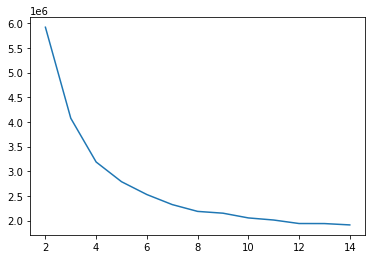

In [18]:
plt.plot(k_list, wssse_list)
plt.show()

### Chọn K=8

In [19]:
# Train a k-means model
kmeans = KMeans(featuresCol='features', k=8)
model = kmeans.fit(clean_data)

In [20]:
# Evaluate clustering by computing within Set Sum of Squared Errors
wssse = model.summary.trainingCost
print("With Set Sum of Squared Errors=", str(wssse))

With Set Sum of Squared Errors= 2185123.75359045


In [21]:
predictions = model.transform(clean_data)

In [22]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         2|
|         4|
|         5|
|         4|
|         1|
+----------+
only showing top 5 rows



In [23]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  287|
|         6|  586|
|         3|   17|
|         5|  724|
|         4|  747|
|         7|  164|
|         2|  412|
|         0|  629|
+----------+-----+



In [24]:
from pyspark.sql.functions import monotonically_increasing_id

In [25]:
data_result = predictions.withColumn('row_index', monotonically_increasing_id())

In [26]:
data_result.show(5)

+--------------------+----------+---------+
|            features|prediction|row_index|
+--------------------+----------+---------+
|(10963,[7,9,28,32...|         2|        0|
|(10963,[2,4,10,21...|         4|        1|
|(10963,[1,2,24,40...|         5|        2|
|(10963,[22,46,50,...|         4|        3|
|(10963,[2,11,70,9...|         1|        4|
+--------------------+----------+---------+
only showing top 5 rows



In [27]:
data_result = data_result.join(data, on=["row_index"]).sort("row_index").drop("row_index")

In [28]:
data_result.show(5)

+--------------------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-----------+------------------+
|            features|prediction|             authors|               title|       publish_date|         description|                text|                 url|length_text|length_description|
+--------------------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-----------+------------------+
|(10963,[7,9,28,32...|         2|        ['Cbc News']|Coronavirus a 'wa...|2020-03-27 08:00:00|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|       2593|               248|
|(10963,[2,4,10,21...|         4|        ['Cbc News']|Yukon gov't names...|2020-03-27 01:45:00|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|       1830|               164|
|(10963,[1,2,24,40...|         5|['The Associated 

In [29]:
stopwords = set(STOPWORDS)
stopwords.add("COVID")
stopwords.add("coronavirus")

In [30]:
def create_word_cloud(pred):
    desc = data_result.filter(data_result.prediction == pred).select(data_result['description']).toPandas()
    
    wc = WordCloud(stopwords=stopwords, max_words=50).generate(' '.join(desc['description']))

    plt.figure(figsize = (10, 12))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

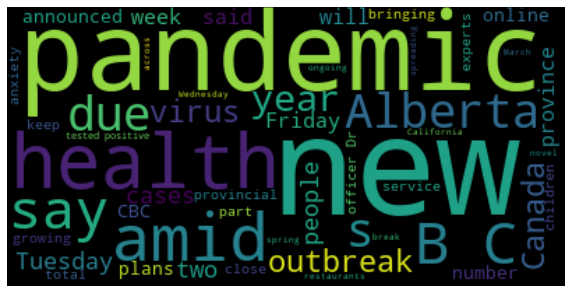

In [31]:
create_word_cloud(0)

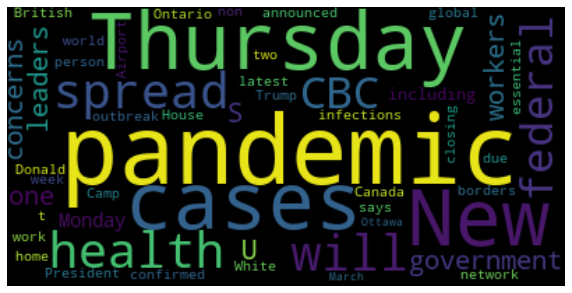

In [32]:
create_word_cloud(1)

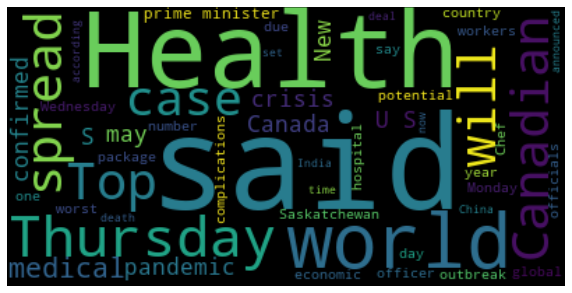

In [33]:
create_word_cloud(2)

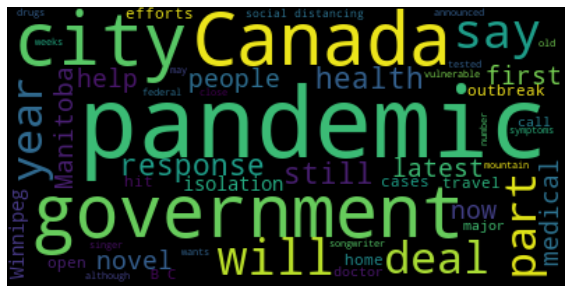

In [35]:
create_word_cloud(4)

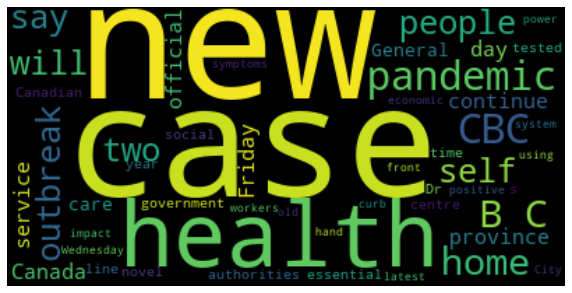

In [36]:
create_word_cloud(5)

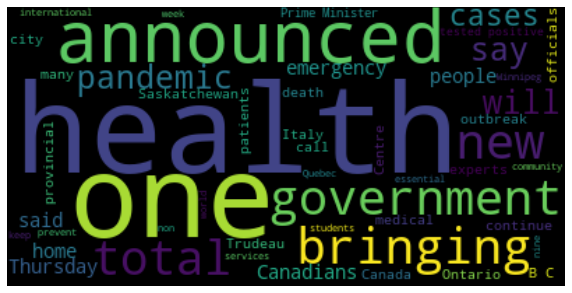

In [37]:
create_word_cloud(6)

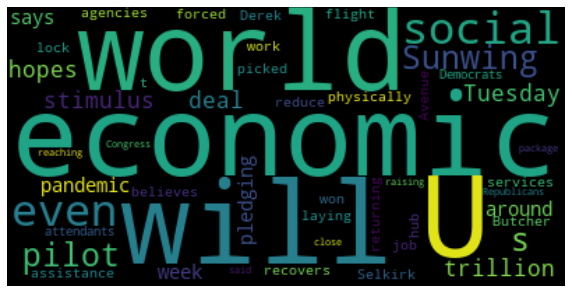

In [38]:
create_word_cloud(7)